# Домашнее задание 1
## Harry Potter and the Action Prediction Challenge from Natural Language


В этом домашнем задании вы будете работать с корпусом Harry Potter and the Action Prediction Challenge. Корпус собран из фанфиков о Гарри Поттере и состоит из двух частей: 1) сырые тексты, 2) фрагменты текстов, описывающих ситуацию, в которой произнесено заклинание.

Корпус описан в статье: https://arxiv.org/pdf/1905.11037.pdf

David Vilares and Carlos Gómez-Rodríguez. Harry Potter and the Action Prediction Challenge from Natural Language. 2019 Annual Conference of the North American Chapter of the Association for Computational Linguistics. To appear.

Код для сбора корпуса находится в репозитории: https://github.com/aghie/hpac . Корпус можно скачать по инструкции из этого репозитория, но для экономии времени авторы задания уже скачали и подготовили данные к работе. 

Ссылки на собранный корпус: 
* Сырые тексты:  https://www.dropbox.com/s/12toaj67fjrguhd/hpac_raw.zip?dl=0
* Токенизированные тексты в нижнем регистре: https://www.dropbox.com/s/1ndto6dce5wg7j2/hpac_lower_tokenized.zip?dl=0
* train-test-dev: https://www.dropbox.com/s/ftinwwjfyydevth/hpac_splits.zip?dl=0

Части 1, 2 задания должны быть выполнены на полных текстах (сырых или предобработанных -- на ваше усмотрение), Часть 3 – на разбиение на тестовое, отладочное и обучающее множества. Тестовое множество должно быть использовано исключительно для тестирования моделей, обучающее и отладочное – для выбора модели и параметров. 

В статье и репозитории вы найдете идеи, которые помогут вам выполнить домашнее задание. Их стоит воспринимать как руководство к действию, и не стоит их копировать и переиспользовать. Обученные модели использовать не нужно, код для их обучения можно использовать как подсказку. 

## ПРАВИЛА
1. Домашнее задание выполняется индивидуально.
2. Домашнее задание сдается в системе Anytask, куда можно попасть через инвайт.
3. Домашнее задание оформляется в отчета в ipython-тетрадке. 
4. Отчет должен содержать: нумерацию заданий и пунктов, которые вы выполнили, код решения, и понятное пошаговое описание того, что вы сделали. Отчет должен быть написан в академическом стиле, без излишнего использования сленга и с соблюдением норм русского языка.
5. Не стоит копировать фрагменты лекций, статей и Википедии в ваш отчет.
6. Плагиат и любое недобросоветсное цитирование приводит к обнуление оценки. 


## Бонусная часть. [2 балла] Skip-Gram Negative Sampling
Самостоятельно реализовать и обучить модель Skip-Gram Negative Sampling. Продемонстрировать качество полученных представлений на конкретный примерах.

# Imports

In [10]:
import os
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from collections import Counter
import nltk
import ssl

from tqdm import tqdm_notebook

import re  
from collections import defaultdict
from typing import List

# Данные
Сырые тексты 

In [3]:
# !unzip hpac_source

In [4]:
# !ls hpac_source | wc -l

In [5]:
# !unzip hpac_splits

In [648]:
# !head -n 3 hpac_splits/hpac_training_128.tsv

train, test, dev файлы

In [2]:
training = pd.read_csv('hpac_splits/hpac_training_128.tsv', sep = '\t', header = None)
test = pd.read_csv('hpac_splits/hpac_test_128.tsv', sep = '\t', header = None)
dev = pd.read_csv('hpac_splits/hpac_dev_128.tsv', sep = '\t', header = None)

In [57]:
training.head(2)

,0,1,2
0,7642954.0.676,RIDDIKULUS,were staring at her . she was up next to face ...
1,10443333.0.5753,RIDDIKULUS,"that whole time . her first reaction , for whi..."


In [60]:
# l = list(set(training[2].unique()).intersection(test[2].unique()))

# len(l)

In [3]:
training['sample'] = 'train'
test['sample'] = 'test'
dev['sample'] = 'dev'

In [4]:
df = pd.concat([training, test, dev])

In [63]:
# del training, test, dev

In [64]:
df.iloc[0][1], df.iloc[0][2]

('RIDDIKULUS',
 "were staring at her . she was up next to face the boggart in defense against the dark arts class . she was not scared , but what she was worried about was what had happened with lysander . she looked up at the boggart in front of her which had previously been a humongous spider . its eyes locked on her . before she could think of what frightened her , the spider transformed into lysander . he was dying . there were giggles coming from the male and female hufflepuff students . there was a smirk on lorcan 's face . `` lily help me '' i ca n't fail this class because of a secret love . lily lifted her wand and said , ``")

# Часть 1. [1 балл] Эксплоративный анализ 

[бонус] Постройте тематическую модель по корпусу HPAC.

[бонус] Найдите еще что-то интересное в корпусе (что-то специфичное для фанфиков или фентези-тематики)


## 1. Найдите топ-1000 слов по частоте без учета стоп-слов.

from collections import Counter 

In [14]:
# фиксим траблы с сертификатами
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruattar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
all_text = ' '.join(df[2].to_list())

In [5]:
sw_filter_func = lambda x: x not in stopwords and x.isalpha()

In [222]:
word_cnt = Counter(filter(sw_filter_func, all_text.split(' ')))

In [11]:
commom_1000 = word_cnt.most_common(1000)

In [12]:
commom_1000[:5]

[('harry', 59043),
 ('wand', 42489),
 ('said', 29459),
 ('could', 28027),
 ('would', 25913)]

## 2 Найдите топ-10 по частоте: имен, пар имя + фамилия

Распарсим имена

https://gist.github.com/jennynz/7eaf7ea4eeb3d686b19e997e721bda0c

In [114]:
# list(filter(lambda x: x[0] in ('mr', 'mrs', 'ms', 'miss'), word_cnt.items()))

In [13]:
with open('Harry Potter names', 'r') as f:
    namelines = f.read().split('\n')

In [14]:
def parse_namelist(s):
    resdict = {
        'name': None,
        'surname': None,
        'middlename': None,
        'title': None,
    }

    if len(s) == 0:
        return resdict
    
    l = s.lower().split(' ')

    if len(l) == 1:
        resdict['name'] = resdict['surname'] = l[0]
        
    elif len(l) > 1:
        
        if l[0] in ('mr', 'miss', 'mrs', 'ms', 'lord'):
            resdict['title'] = l[0]
            l = l[1:]
        
        resdict['name'] = l[0]    
        resdict['surname'] = l[-1]
        
    if len(l) > 2:
        resdict['middlename'] = ' '.join(l[1:-1])
        
    return resdict

In [455]:
parsed_names = pd.DataFrame(map(parse_namelist, namelines))

new_row = {
    'name': 'ginny',
    'surname': "weasley",
    'middlename': None,
    'title': None,
}

parsed_names = parsed_names._append(new_row, ignore_index=True)

In [28]:
names = parsed_names.name.unique()

In [31]:
popular_names = sorted(
    list(filter(lambda x: x[0] in names, word_cnt.items())),
    key=lambda x: x[1],
    reverse=True
)

Топ популярных имен:

In [33]:
popular_names[:5]

[('harry', 59043),
 ('hermione', 24062),
 ('draco', 21266),
 ('voldemort', 16091),
 ('sirius', 9929)]

Ищем имя + фамилия

In [11]:
text = df[df[2].str.contains('harry potter')].iloc[19, 2]
re.findall('harry potter', text)

['harry potter']

In [12]:
def count_mentions(names: List[str], text: str, mentions: defaultdict):
    """  
    Считает количество упоминаний имен и фамилий в тексте и добавляет их в mentions  
  
    Args:  
        names (list): Список строк вида "имя фамилия".  
        text (str): Текст, в котором нужно найти упоминания.  
        mentions (defaultdict): словарь счетчик
    Returns:  None  
    """  
    for name in tqdm_notebook(names):  
        pattern = re.compile(r'\b' + re.escape(name) + r'\b', re.IGNORECASE)  
        mentions[name] += len(pattern.findall(text))   

Так, упоминание имя + фамилия это подможество упоминаний имени, поэтому чтобы не искать по всем именам и фамилиям, можем список name_surname_lst фильтрануть на топ имен

In [121]:
top_30_names = [i[0] for i in popular_names[:30]]

In [130]:
name_surname_df = parsed_names.query("name.isin(@top_30_names)")
name_surname_lst = sorted(
    list(
        set(
            name_surname_df['name'] + ' ' + name_surname_df['surname'].str.replace(')', '')
        )
    )
)

In [133]:
len(name_surname_lst)

40

In [136]:
MENTIONS = defaultdict(int)

count_mentions(name_surname_lst, all_text, MENTIONS)

/var/folders/yh/4jky_nln065c8nrzc6phgjjdt0k6bs/T/ipykernel_69006/1668062734.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for name in tqdm_notebook(names):


  0%|          | 0/40 [00:00<?, ?it/s]

In [140]:
sorted(list(MENTIONS.items()), key=lambda x: x[1], reverse=True)[:10]

[('harry potter', 3178),
 ('draco malfoy', 1058),
 ('james potter', 762),
 ('severus snape', 713),
 ('hermione granger', 634),
 ('lucius malfoy', 629),
 ('sirius black', 499),
 ('albus dumbledore', 378),
 ('remus lupin', 290),
 ('lily evans', 266)]

<!-- ## [bonus] Постройте тематическую модель по корпусу HPAC. -->

# Часть 2. [2 балла] Модели представления слов 
Обучите модель представления слов (word2vec, GloVe, fastText или любую другую) на материале корпуса HPAC.

In [6]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

In [15]:
# data_tok = [tokenizer.tokenize(x[1][2]) for x in df.iterrows()]

data_tok = [
    list(filter(sw_filter_func, tokenizer.tokenize(x[1][2].lower())))
    for x in df.iterrows()
]

In [16]:
from gensim.models import Word2Vec
model = Word2Vec(data_tok,
                 vector_size=32,      # embedding vector size
                 min_count=10,  # consider words that occured at least 10 times
                 window=5).wv

## 1. Продемонстрируйте, как работает поиск

Продемонстрируйте, как работает поиск синонимов, ассоциаций, лишних слов в обученной модели. 

Похожие слова находятся неплохо: для Гарри получаем имена других волшебников, для заклинания - синонимы слова и частные применения заклинаний (shield, patronus)

In [232]:
model.most_similar('harry')

[('hermione', 0.7381895780563354),
 ('ron', 0.7332048416137695),
 ('draco', 0.6951807141304016),
 ('ginny', 0.6894742846488953),
 ('cedric', 0.6752374768257141),
 ('finally', 0.6291574835777283),
 ('voldemort', 0.5753096342086792),
 ('soon', 0.5702435374259949),
 ('alicia', 0.5685431361198425),
 ('alex', 0.566909670829773)]

In [231]:
model.most_similar('spell')

[('charm', 0.8001124262809753),
 ('jinx', 0.7807850241661072),
 ('curse', 0.7784588932991028),
 ('stunner', 0.7772358059883118),
 ('spells', 0.7618021965026855),
 ('hex', 0.696738600730896),
 ('incantation', 0.6952868700027466),
 ('target', 0.6668296456336975),
 ('distraction', 0.6603333950042725),
 ('instinct', 0.6571776270866394)]

`doesnt_match` возвращает слово, которое не имеет близких значений или ассоциаций с другими словами в списке. 

И как мы видим, выведенные слова действительно есть в вокабуляре word2vec'a, т. е. дело именно в отсутствии ассоциаций

In [233]:
model.doesnt_match(['marriage', 'harry', 'ron', 'draco', 'fight'])

'marriage'

In [234]:
'marriage' in model.key_to_index

True

In [235]:
model.doesnt_match(['spell', 'incantation', 'patronus', 'hex', 'refrigerator'])

'refrigerator'

In [236]:
'refrigerator' in model.key_to_index

True

теперь поскладываем векторы

Думаю Драко Малфой кайфанул бы с результатов следующей ячейки

In [244]:
model.most_similar(positive=["faculty", "bravery"], negative=["brain"])

[('glory', 0.812431812286377),
 ('champion', 0.8022547960281372),
 ('rival', 0.8000054955482483),
 ('muggleborn', 0.7925584316253662),
 ('officially', 0.7901118397712708),
 ('heirs', 0.7778529524803162),
 ('supporter', 0.7679476737976074),
 ('meddling', 0.7676731944084167),
 ('sorted', 0.7676534056663513),
 ('united', 0.758999764919281)]

минутка экзистенциального

In [245]:
model.most_similar(positive=["love", "pain"])

[('misery', 0.800972580909729),
 ('hurts', 0.723066508769989),
 ('excruciating', 0.7141058444976807),
 ('agony', 0.702722430229187),
 ('hate', 0.6998796463012695),
 ('pride', 0.6943086385726929),
 ('regret', 0.6906284689903259),
 ('sorrow', 0.6880046129226685),
 ('hurting', 0.6824453473091125),
 ('forever', 0.6800863742828369)]

## 2. Порисуем

2. Визуализируйте топ-1000 слов по частоте без учета стоп-слов (п. 1.1) с помощью TSNE или UMAP (https://umap-learn.readthedocs.io).

In [17]:
words = model.index_to_key[:1000]

word_vectors = np.array([model.get_vector(x) for x in words])

In [19]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

Loading BokehJS ...

In [267]:
# ## pca интереса ради

# pca = PCA(n_components=2)
# word_vectors_pca = pca.fit_transform(word_vectors)

# scaler = StandardScaler()
# word_vectors_pca = scaler.fit_transform(word_vectors_pca)

# draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words);

все правда, лучше не думать

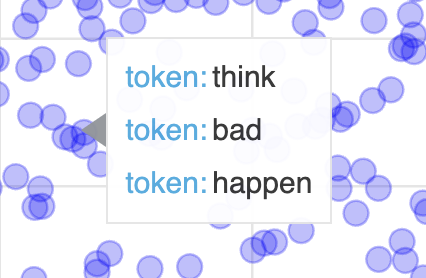

**TSNE**

In [20]:
tsne = TSNE(n_components=2, random_state=45, n_iter=5000)
word_tsne = tsne.fit_transform(word_vectors)

scaler = StandardScaler()
word_tsne = scaler.fit_transform(word_tsne)

/Users/ruattar/study/university/NLP/myenv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [21]:
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='pink', token=words);

получили например кластер векторов для измерения времени, неплохо

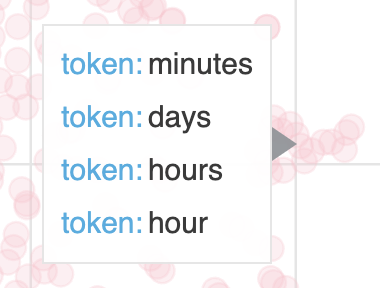

или вот, уголочек Володи

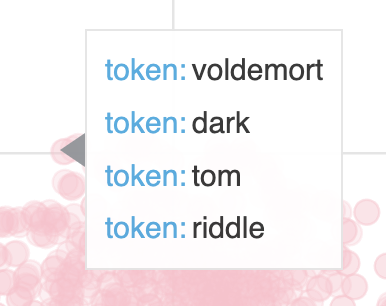


или вот, кластер коммуникаций 

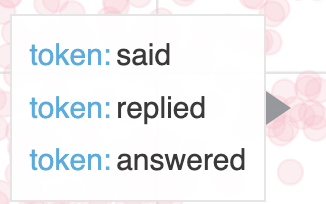

# Часть 3. [6.5 баллов] Классификация текстов
Задача классификации формулируется так: данный фрагмент фанфика описывают какую-то ситуацию, которая предшествует произнесению заклинания. Требуется по тексту предсказать, какое именно заклинание будет произнесено. Таким образом, заклинание - это фактически метка класса. Основная мера качества – macro $F_1$.
Обучите несколько классификаторов и сравните их между собой. Оцените качество классификаторов на частых и редких классах. Какие классы чаще всего оказываются перепутаны? Связаны ли ошибки со смыслом заклинаний?

Используйте фрагменты из множества train для обучения, из множества dev для отладки, из множества test – для тестирования и получения итоговых результатов. 

<!-- 1. [1 балл] Используйте fastText в качестве baseline-классификатора. -->
<!-- 2. [2 балла] Используйте сверточные сети в качестве более продвинутого классификатора. Поэкспериментируйте с количеством и размерностью фильтров, используйте разные размеры окон, попробуйте использовать $k$-max pooling. -->
<!-- 3. [2 балла] Используйте рекуррентные сети в качестве альтернативного продвинутого классификатора. Поэкспериментируйте с количеством и размерностью слоев и другими гиперпараметрами.  -->

[бонус] Используйте результат max pooling'а как эмбеддинг входного текста. Визуализируйте эмбеддинги 500-1000 предложений из обучающего множества и изучите свойства получившегося пространства.

[бонус] Используйте ваш любимый классификатор и любые (честные) способы повышения качества классификации и получите macro $F_1$ больше 0.5.

## 1. FastText

In [515]:
df[3] = [' '.join(i).lower() for i in data_tok]

In [516]:
spells = sorted(df.query("sample == 'train'")[1].unique())

class_dict = {i: j for i, j in enumerate(spells)}
class_dict_reverse = {j: i for i, j in enumerate(spells)}

In [517]:
df['class'] = df[1].map(class_dict_reverse)

In [559]:
def prep_sample(df, sample_name, path='./data'):
    assert sample_name in ('train', 'test', 'dev'), 'wrong sample name'

    sample = (
        df
        .query("sample == @sample_name")
        # .drop(columns=['sample', 1, 0, 2])
        .rename(columns={3: 'text'})
        .query("text.str.len() > 1")
        [['class', 'text']]
    )

    return sample

In [560]:
def write_sample_to_txt(
    df,
    sample_name,
    path='./data',
    text_col_name='text',
    class_col_name='class'
):
    if not os.path.exists(path):
        os.makedirs(path)

    file_path = os.path.join(path, f'{sample_name}.txt')
    
    with open(file_path, 'w') as f:
        for text, label in zip(df[text_col_name], df[class_col_name]):
            f.writelines(f'__label__{label} {text}\n')

    print(file_path, "written")

In [561]:
for s_name in ('train', 'test', 'dev'):
    
    sample = prep_sample(df, s_name)

    if not os.path.exists('./csv_data'):
        os.makedirs('./csv_data')
        
    sample.to_csv(f'./csv_data/{s_name}.csv', index=False)

    write_sample_to_txt(sample, s_name)

./data/train.txt written
./data/test.txt written
./data/dev.txt written


In [564]:
pd_train = pd.read_csv('./csv_data/train.csv')
pd_test = pd.read_csv('./csv_data/test.csv')
pd_dev = pd.read_csv('./csv_data/dev.csv')

In [563]:
!head -n 3 ./data/test.txt

__label__80 eyes wide full apologies n yet said probably would n ever say tried touch arm consolation done slapped away hermione n mean said n speak louder whisper voice still pounded head could almost feel angry tears splash fist turned jerk worst part look face worried nervous freaked either way made want
__label__11 picking power bones forefathers squabbling one another scraps power never lord true power n know classify look dark lord face anyone else would thought touched brushed cheek ends fingers show said value power blood show strength might admire bellatrix pressed tip wand right sternum feeling clearly robes
__label__0 last time lily seen black hair electric blue hair wore square black glasses heavily outlined pierced lip american nice hair said lily die week ago aimie answered mom pissed ca n imagine sires exclaimed aimie slapped back head shut nope sires grabbed hat wearing head ran aimie rolled eyes took wand


In [412]:
# del data_tok, df # чистим оперативу
# del training, test, dev

In [448]:
train_file = './data/train.txt'
test_file = './data/test.txt'

In [521]:
from fasttext import train_supervised 
"""fastText expects and training file (csv), a model name as input arguments.
label_prefix refers to the prefix before label string in the dataset.
default is __label__. In our dataset, it is __class__. 
"""
ft_model = train_supervised(
    input=train_file,
    label="__label__",
    lr=1.0,
    epoch=70,
    loss='ova',
    wordNgrams=2,
    dim=100,
    thread=2,
    verbose=100
)

Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 2650312 lr:  0.000000 avg.loss:  4.054260 ETA:   0h 0m 0s


In [597]:
def fastext_predict(model, pred_text: list):
    ft_predictions = [model.predict(i) for i in pred_text]
    return [int(i[0][0].replace('__label__', '')) for i in ft_predictions]

In [607]:
# предсказания
ft_predictions_int = fastext_predict(ft_model, pd_test['text'].to_list())

# правильные метки
true_labels = pd_test['class'].to_list()

from sklearn.metrics import f1_score

# Расчитаем метрику macro F1  
macro_f1 = f1_score(true_labels, ft_predictions_int, average='macro')  
print('FastText macro F1:', round(macro_f1, 3))  

FastText macro F1: 0.141


In [595]:
import itertools  
  
param_grid = {  
    'lr': [0.2, 0.5, 1.0],  
    'epoch': [50],  
    'wordNgrams': [1, 2, 3],  
    'dim': [50, 100, 200],  
    'thread': [2]  
}  
  
# Используем itertools.product для создания сетки  
grid = list(itertools.product(*param_grid.values()))  
  
# Преобразуем сетку в список словарей  
grid = [{'lr': lr, 'epoch': ep, 'wordNgrams': wn, 'dim': d, 'thread': t}  
        for lr, ep, wn, d, t in grid]  
  
len(grid)

27

In [575]:
true_labels = pd_test['class'].to_list()

len(true_labels)

7672

In [578]:
from sklearn.metrics import f1_score

# Расчитать метрику macro F1  
macro_f1 = f1_score(true_labels, ft_predictions_int, average='macro')  
print('FastText macro F1:', macro_f1)  

FastText macro F1: 0.14086978842880496


Так, что ж

Метрика не 0, и это уже успех. 

Попробуем немного подвигать параметры:

In [614]:
results = {}

true_labels_val = pd_dev['class'].to_list()

for i, params in tqdm_notebook(enumerate(grid)):

    ft_model_val = train_supervised(
        input=train_file,
        label="__label__",
        loss='ova',
        verbose=100,
        **params
    )

    ft_predictions_int_val = fastext_predict(ft_model_val, pd_dev['text'].to_list())
    macro_f1_val = f1_score(true_labels_val, ft_predictions_int_val, average='macro')

    results[i] = macro_f1_val
    
    print('iter:', i, 'f1:', macro_f1_val)

/var/folders/yh/4jky_nln065c8nrzc6phgjjdt0k6bs/T/ipykernel_69006/1403518944.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, params in tqdm_notebook(enumerate(grid)):


0it [00:00, ?it/s]

Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 7290770 lr:  0.000000 avg.loss:  1.731616 ETA:   0h 0m 0s
Read 2M words

iter: 0 f1: 0.13901749127518273


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 3818889 lr:  0.000000 avg.loss:  1.736874 ETA:   0h 0m 0s
Read 2M words

iter: 1 f1: 0.13991459605651566


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 2105486 lr:  0.000000 avg.loss:  1.740054 ETA:   0h 0m 0s
Read 1M words

iter: 2 f1: 0.13899385639070705


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 4726849 lr:  0.000000 avg.loss:  0.967128 ETA:   0h 0m 0s


iter: 3 f1: 0.149576719610114


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 2613656 lr:  0.000000 avg.loss:  0.982106 ETA:   0h 0m 0s


iter: 4 f1: 0.1474057806654217


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 1455803 lr:  0.000000 avg.loss:  0.996176 ETA:   0h 0m 0s


iter: 5 f1: 0.14574783517710543


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 3309886 lr:  0.000000 avg.loss:  1.113314 ETA:   0h 0m 0s


iter: 6 f1: 0.14205144382283888


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 2002093 lr:  0.000000 avg.loss:  1.138869 ETA:   0h 0m 0s


iter: 7 f1: 0.14369782357867308


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 1115893 lr:  0.000000 avg.loss:  1.156302 ETA:   0h 0m 0s


iter: 8 f1: 0.1436099422952543


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 8103303 lr:  0.000000 avg.loss:  1.045209 ETA:   0h 0m 0s


iter: 9 f1: 0.1435223720836213


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 3734187 lr:  0.000000 avg.loss:  1.423368 ETA:   0h 0m 0s
Read 2M words

iter: 10 f1: 0.14682123599413274


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 2238173 lr:  0.000000 avg.loss:  1.360778 ETA:   0h 0m 0s


iter: 11 f1: 0.14301420672021092


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 4847232 lr:  0.000000 avg.loss:  0.544540 ETA:   0h 0m 0s


iter: 12 f1: 0.16637902262449633


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 2647884 lr:  0.000000 avg.loss:  0.553903 ETA:   0h 0m 0s


iter: 13 f1: 0.16411682515006557


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 1468571 lr:  0.000000 avg.loss:  0.560690 ETA:   0h 0m 0s


iter: 14 f1: 0.1619600643381096


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 3410372 lr:  0.000000 avg.loss:  0.557451 ETA:   0h 0m 0s


iter: 15 f1: 0.16571361552910838


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 2026607 lr:  0.000000 avg.loss:  0.570642 ETA:   0h 0m 0s


iter: 16 f1: 0.16625950698495826


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 1145203 lr:  0.000000 avg.loss:  0.579630 ETA:   0h 0m 0s


iter: 17 f1: 0.16779031530025476


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 8023362 lr:  0.000000 avg.loss:  1.656839 ETA:   0h 0m 0s
Read 2M words

iter: 18 f1: 0.11949434705611073


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 4113812 lr:  0.000000 avg.loss:  1.932644 ETA:   0h 0m 0s


iter: 19 f1: 0.13511219721008882


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 2301778 lr:  0.000000 avg.loss:  1.770451 ETA:   0h 0m 0s
Read 1M words

iter: 20 f1: 0.13373464186018338


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 5125605 lr:  0.000000 avg.loss:  0.475988 ETA:   0h 0m 0s
Read 2M words

iter: 21 f1: 0.15772490535813818


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 2769298 lr:  0.000000 avg.loss:  0.757293 ETA:   0h 0m 0s


iter: 22 f1: 0.15318274311483912


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 1529749 lr:  0.000000 avg.loss:  0.676020 ETA:   0h 0m 0s


iter: 23 f1: 0.15987042302797383


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 3505039 lr:  0.000000 avg.loss:  0.445627 ETA:   0h 0m 0s


iter: 24 f1: 0.16488167123541467


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 2047722 lr:  0.000000 avg.loss:  0.480206 ETA:   0h 0m 0s


iter: 25 f1: 0.1617558956858159


Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 1135600 lr:  0.000000 avg.loss:  0.457233 ETA:   0h 0m 0s


iter: 26 f1: 0.16276767744664186


In [629]:
grid[sorted(list(results.items()), key=lambda x: x[1])[-1][0]]

{'lr': 0.5, 'epoch': 50, 'wordNgrams': 3, 'dim': 200, 'thread': 2}

In [626]:
best_params = {'lr': 0.5, 'epoch': 100, 'wordNgrams': 3, 'dim': 200, 'thread': 2}

In [628]:
ft_model_final = train_supervised(
    input=train_file,
    label="__label__",
    loss='ova',
    verbose=100,
    **best_params
)

Read 3M words
Number of words:  48533
Number of labels: 85
Progress: 100.0% words/sec/thread: 1117536 lr:  0.000000 avg.loss:  0.302738 ETA:   0h 0m 0s


In [635]:
ft_model_final.save_model('fasttext_model_final.bin')

In [637]:
ft_model_final = fasttext.load_model('fasttext_model_final.bin')

macro_f1 = f1_score(true_labels,
                    fastext_predict(ft_model_final, pd_test['text'].to_list()),
                    average='macro')  

print('FastText macro F1:', round(macro_f1, 3))  

FastText macro F1: 0.174


## Подготовка для NN

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import random
from collections import Counter

from sklearn.metrics import f1_score

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

set_seed(42)

Using device: cuda


In [22]:
pd_train = pd.read_csv('./csv_data/train.csv')
pd_test = pd.read_csv('./csv_data/test.csv')
pd_dev = pd.read_csv('./csv_data/dev.csv')

In [3]:
spells = sorted(pd_train['class'].unique())

class_dict = {i: j for i, j in enumerate(spells)}
class_dict_reverse = {j: i for i, j in enumerate(spells)}

In [25]:
len(class_dict)

85

1) сначала мы делаем словарь для токенов (добавляя туда unk и pad)

как делали на семинаре, сначала пофильтруем еще редкие токены

In [6]:
train_tokens_count = Counter(' '.join(pd_train['text'].to_list()).split(' '))

min_count = 5

tokens = sorted(t for t, c in train_tokens_count.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

print("len(tokens):", len(tokens))

### наш словарик
token_to_id = {k:i for i, k in enumerate(tokens)}

len(tokens): 20505


In [56]:
print(pd_train.head(3))

   class                                               text
0     72  staring next face boggart defense dark arts cl...
1     72  whole time first reaction felt quite proud sin...
2     80  watched inglorious withdrawal together accompa...


2) потом представляем токенизированные тексты в виде векторов int

делаем их одинаковой длинны (т е заполняем лишнее паддингами)

In [7]:
MAX_LEN = pd_train.text.str.split(' ').apply(len).max()

MAX_LEN

105

In [8]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

Создадим датасеты для сеток

In [9]:
# Создание Dataset и DataLoader
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
X_train = as_matrix(pd_train['text'].to_list(), max_len=MAX_LEN)
y_train = pd_train['class'].values

X_test = as_matrix(pd_test['text'].to_list(), max_len=MAX_LEN)
y_test = pd_test['class'].values

X_dev = as_matrix(pd_dev['text'].to_list(), max_len=MAX_LEN)
y_dev = pd_dev['class'].values

In [11]:
BATCH_SIZE = 128

In [12]:
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)
dev_dataset = TextDataset(X_dev, y_dev)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)

Определим общие функции для тренировки и оценки

In [13]:
# Функция для обучения модели
def train_model(model, train_loader, dev_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
        
        # # Оценка модели на валидационном наборе данных
        evaluate_model(model, dev_loader)
        model.train()

# Функция для оценки модели
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(y_batch.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Вычисление метрик
    accuracy = (np.array(all_predictions) == np.array(all_labels)).mean()
    f1_macro = f1_score(all_labels, all_predictions, average='macro')
    f1_weighted = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Accuracy: {100 * accuracy:.2f}%',
          f'F1 Macro: {f1_macro:.4f}',
          f'F1 Weighted: {f1_weighted:.4f}'
         )

## 2. Conv NN

2. [2 балла] Используйте сверточные сети в качестве более продвинутого классификатора. Поэкспериментируйте с количеством и размерностью фильтров, используйте разные размеры окон, попробуйте использовать $k$-max pooling.

In [45]:
# Определение CNN-модели
class TextCNN(nn.Module):
    def __init__(
        self,vocab_size=None,
        embed_size=300,
        kernel_sizes=[2],
        num_filters=[6],
        num_classes=2,
        dropout=0.3
    ):
        super(TextCNN, self).__init__()
        self.embed_size = embed_size
        # TO DO: implement pretrained embeddings (?)
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self.embed_size,
            padding_idx=PAD_IX
        )
        # Conv1d
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(
                in_channels=self.embed_size,
                out_channels=num_filters[i],
                kernel_size=kernel_sizes[i]
            )
            for i in range(len(kernel_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc1 = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """
        1) embedding 
        2) reshape
        3) covolutions (as list?)
        4) pooling
        5) linear
        """

        # (bs, max_len, embed_size)
        x = self.embedding(input_ids).float()

        # match input shape requirement of nn.Conv1d
        # (bs, embed_size, max_len)
        x = x.permute(0, 2, 1)

        # CNN & ReLU
        # (bs, num_filters[i], L_out)
        conv_list = [F.relu(conv1d(x)) for conv1d in self.conv1d_list]

        # Max pooling
        # (bs, num_filters[i], 1)
        pool_list = [F.max_pool1d(c, kernel_size=c.shape[2]) for c in conv_list]

        # Concatenate x's from pool_list
        # Output shape: (bs, sum(num_filters))
        x_fc = torch.cat(
            [x_p.squeeze(dim=2) for x_p in pool_list], 
            dim=1
        )

        # Output shape: (bs, n_classes)
        return self.fc1(self.dropout(x_fc))

In [90]:
# kernel_sizes = [2, 3, 4]
# num_filters = [64, 64, 64]

kernel_sizes = [3, 4, 5]
num_filters = [128] * len(kernel_sizes)
assert len(kernel_sizes) == len(num_filters), 'alarm'

num_classes = len(np.unique(y_train))
vocab_size = len(token_to_id)
embed_size = 300

model = TextCNN(
    vocab_size=vocab_size,
    embed_size=embed_size,
    kernel_sizes=kernel_sizes,
    num_filters=num_filters,
    num_classes=num_classes,
    dropout=0.1,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, dev_loader, criterion, optimizer, num_epochs=10)

evaluate_model(model, test_loader);

Epoch [1/10], Loss: 3.2313
Accuracy: 26.78% F1 Macro: 0.0602 F1 Weighted: 0.2209
Epoch [2/10], Loss: 2.7983
Accuracy: 28.06% F1 Macro: 0.0741 F1 Weighted: 0.2483
Epoch [3/10], Loss: 2.4602
Accuracy: 29.62% F1 Macro: 0.0842 F1 Weighted: 0.2551
Epoch [4/10], Loss: 2.0797
Accuracy: 29.39% F1 Macro: 0.1013 F1 Weighted: 0.2610
Epoch [5/10], Loss: 1.6593
Accuracy: 28.98% F1 Macro: 0.1147 F1 Weighted: 0.2679
Epoch [6/10], Loss: 1.2216
Accuracy: 28.69% F1 Macro: 0.1217 F1 Weighted: 0.2628
Epoch [7/10], Loss: 0.8536
Accuracy: 27.44% F1 Macro: 0.1342 F1 Weighted: 0.2564
Epoch [8/10], Loss: 0.6056
Accuracy: 26.78% F1 Macro: 0.1294 F1 Weighted: 0.2621
Epoch [9/10], Loss: 0.4671
Accuracy: 27.48% F1 Macro: 0.1340 F1 Weighted: 0.2583
Epoch [10/10], Loss: 0.3906
Accuracy: 27.67% F1 Macro: 0.1223 F1 Weighted: 0.2565
Accuracy: 28.31% F1 Macro: 0.1379 F1 Weighted: 0.2636


В текущем сетапе это +/- максимум кажется, и изменения гиперпараметров (относительно наивное правда) прироста не дает 

В целом если ресурсы позволяют, наверное можно так и до 0.2 дотянуть, но кажется это чересчур экстенсивный подход и лучше как-то по-другому сделать 

Бейзлайн не побит пока, но! Во-первых, он сам по себе неплохой получился, а во вторых качество хотя бы +/- сопоставимо с референсом, что уже успех, так как с одной сверткой получалась совсем беда

## 3. RNN

Используйте рекуррентные сети в качестве альтернативного продвинутого классификатора. Поэкспериментируйте с количеством и размерностью слоев и другими гиперпараметрами. 

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_size,
        hidden_size,
        num_classes,
        dropout=0.1,
        bidirectional=True,
        hidden_linear_size = 128,
        n_layers = 2,
    ):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=PAD_IX,)
        self.rnn = nn.LSTM(
            embed_size,
            hidden_size,
            batch_first=True,
            bidirectional=bidirectional,
            num_layers=n_layers,
            dropout=dropout
        )
        
        self.lstm_out_size = hidden_size * (1 + int(bidirectional))
        
        self.hidden_fc1 = nn.Linear(self.lstm_out_size, hidden_linear_size)
        self.hidden_fc2 = nn.Linear(hidden_linear_size, self.lstm_out_size)
        
        self.final_fc = nn.Linear(self.lstm_out_size, num_classes)
        
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional
        self.batchnorm = nn.BatchNorm1d(self.lstm_out_size)
        
        # Инициализация весов
        self.init_weights()

    def init_weights(self):
        # Инициализация весов для embedding
        nn.init.xavier_uniform_(self.embedding.weight)
        
        # Инициализация весов для LSTM
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:  # Веса для входов
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:  # Смещения
                nn.init.constant_(param.data, 0)

        # # Инициализация весов для полносвязного слоя
        # nn.init.xavier_uniform_(self.fc.weight)
        # nn.init.constant_(self.fc.bias, 0)

    def forward(self, x):
        # Применяем слой embedding
        # h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)  
        # c0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device) 
        # out, _ = self.rnn(x, (h0, c0))
        
        x = self.embedding(x)
        
        # проход через LSTM
        x, (hn, cn) = self.rnn(x)
        
        # print(x.shape)
        
        if self.bidirectional:
            x = torch.cat(
                (
                    x[:, -1, :self.rnn.hidden_size],
                    x[:, 0, self.rnn.hidden_size:]
                ),
                dim=1
            ) 
        else:
            x = x[:, -1, :]
        
        # print(x.shape)
            
       
        # x = self.batchnorm(x)
        # # Оборачиваем в скрытый линейный слой
        # x = self.hidden_fc1(x)
        # x = F.relu(x)
        # x = self.hidden_fc2(x)
        # x = F.relu(x)
        x = self.final_fc(x)
        
        # print(x.shape)
        return x

Будем использовать те же функции для трейна: они в целом универсальны

In [54]:
# Пример инициализации модели
vocab_size = len(token_to_id) 
embed_size = 100
hidden_size = 64  # Можно изменить в зависимости от задачи
num_classes = len(set(y_train))  # Число классов для классификации
dropout_rate = 0.1
n_layers = 2

# Инициализация модели и перенос на устройство
rnn_model = RNNModel(
    vocab_size,
    embed_size,
    hidden_size,
    num_classes,
    dropout_rate,
    n_layers=n_layers,
    hidden_linear_size= hidden_size * 2,
    bidirectional=True,
).to(device)

# Инициализация потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.25)

# Обучение модели
train_model(rnn_model, train_loader, dev_loader, criterion, rnn_optimizer, num_epochs=30)

# Оценка модели на тестовом наборе данных
evaluate_model(rnn_model, test_loader)

Epoch [1/30], Loss: 4.0324
Accuracy: 12.13% F1 Macro: 0.0026 F1 Weighted: 0.0263
Epoch [2/30], Loss: 3.6858
Accuracy: 10.92% F1 Macro: 0.0039 F1 Weighted: 0.0371
Epoch [3/30], Loss: 3.6825
Accuracy: 12.15% F1 Macro: 0.0026 F1 Weighted: 0.0264
Epoch [4/30], Loss: 3.6636
Accuracy: 8.76% F1 Macro: 0.0036 F1 Weighted: 0.0288
Epoch [5/30], Loss: 3.6143
Accuracy: 11.35% F1 Macro: 0.0025 F1 Weighted: 0.0234
Epoch [6/30], Loss: 3.6027
Accuracy: 11.30% F1 Macro: 0.0025 F1 Weighted: 0.0231


KeyboardInterrupt: 

Какие-то ухищрения с доп линейными слоями не дают импакта, и модель все равно не учится

Пробовал делать пуллинг из выхода LSTM, результат все то же

Видимо не до конца пониманию как RNN-ки работают, не исключаю что принципиально что-то не то делаю

## 4.  Аугментация 

[1.5 балла] Попробуйте расширить обучающее множество за счет аугментации данных. Если вам понадобится словарь синонимов, можно использовать WordNet (ниже вы найдете примеры).

### Как использовать WordNet из nltk?

In [50]:
# скачиваем WordNet
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/ruattar/nltk_data...
[nltk_data] Downloading package omw-1.4 to /Users/ruattar/nltk_data...


True

In [58]:
# слово -> множество синсетов (синонимов разных смыслов исходного слова)
from nltk.corpus import wordnet as wn
wn.synsets('magic')

[Synset('magic.n.01'), Synset('magic_trick.n.01'), Synset('charming.s.02')]

In [91]:
# посмотрим, что внутри одного синсета
wn.synsets('magic')

[Synset('magic.n.01'), Synset('magic_trick.n.01'), Synset('charming.s.02')]

In [62]:
# возьмем лемму одного из слов из синсета
wn.synsets('magic')[1].lemmas()[-1].name()

'deception'

In [46]:
import nltk
from nltk.corpus import wordnet
import random
from tqdm import tqdm_notebook

def synonym_augmentation(text, probability=0.3):
    """
    Функция для замены слов в тексте на их синонимы.
    :param text: Исходный текст.
    :param probability: Вероятность замены каждого слова на синоним.
    :return: Текст с замененными словами.
    """
    words = text.split(' ')
    augmented_text = [0] * len(words)
    
    for word_idx in range(len(words)):
        word = words[word_idx]
        if random.random() < probability:  # Определяем, нужно ли заменить слово
            synonyms = wordnet.synsets(word)
            if synonyms:
                synonym = synonyms[0].lemmas()[0].name()  # Берем первый синоним
                augmented_text[word_idx] = synonym.lower()
            else:
                augmented_text[word_idx] = word
        else:
            augmented_text[word_idx] = word
    
    return ' '.join(augmented_text)


In [51]:
# Пример использования
sample_text = pd_train['text'][1]  # Берем пример текста
augmented_text = synonym_augmentation(sample_text, probability=0.3)

print("Original:", sample_text)
print("-"*20)
print("Augmented:", augmented_text)

Original: whole time first reaction felt quite proud since practicality tough state mind whatever swerve around check see anyone watching relief everyone focused entrapping last boggarts last boggarts supposed exception one standing rose took deep breath said thank cooperation experiment produced enlightening results um rose best channel hysterical laughter bubbling dangerously throat screamed
--------------------
Augmented: whole time first reaction felt quite proud since practicality tough state mind whatever swerve about check see anyone watching relief everyone concentrate entrapping last boggarts stopping_point boggarts supposed exception one standing rose took deep breath said thank cooperation experiment produce enlighten consequence um rose best channel hysterical laughter bubbling perilously throat screamed


In [82]:
augmented_texts = [synonym_augmentation(text, probability=0.3) for text in pd_train['text']]

In [83]:
pd_augmented = pd.DataFrame({
    'class': pd_train['class'].tolist(),
    'text': augmented_texts
})

In [86]:
pd_train_augmented = pd.concat([pd_train, pd_augmented.sample(frac=0.5)])

pd_train_augmented = pd_train_augmented.sample(frac=1).reset_index(drop=True)

# Преобразование для обучения
X_train_augmented = as_matrix(pd_train_augmented['text'].to_list(), max_len=MAX_LEN)
y_train_augmented = pd_train_augmented['class'].values

# Создаем обновленный датасет и DataLoader
train_dataset_augmented = TextDataset(X_train_augmented, y_train_augmented)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=BATCH_SIZE, shuffle=True)


In [87]:
# kernel_sizes = [2, 3, 4]
# num_filters = [64, 64, 64]

kernel_sizes = [3, 4, 5]
num_filters = [128] * len(kernel_sizes)

assert len(kernel_sizes) == len(num_filters), 'alarm'

num_classes = len(np.unique(y_train))
vocab_size = len(token_to_id)
embed_size = 300

cnn_model = TextCNN(
    vocab_size=vocab_size,
    embed_size=embed_size,
    kernel_sizes=kernel_sizes,
    num_filters=num_filters,
    num_classes=num_classes,
    dropout=0.1,
).to(device)

criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

train_model(cnn_model, train_loader_augmented, dev_loader, criterion, cnn_optimizer, num_epochs=10)

evaluate_model(cnn_model, test_loader);

Epoch [1/10], Loss: 3.1063
Accuracy: 27.26% F1 Macro: 0.0664 F1 Weighted: 0.2231
Epoch [2/10], Loss: 2.5502
Accuracy: 27.35% F1 Macro: 0.0791 F1 Weighted: 0.2344
Epoch [3/10], Loss: 2.0069
Accuracy: 28.42% F1 Macro: 0.1014 F1 Weighted: 0.2559
Epoch [4/10], Loss: 1.4345
Accuracy: 27.48% F1 Macro: 0.1239 F1 Weighted: 0.2579
Epoch [5/10], Loss: 0.9387
Accuracy: 26.80% F1 Macro: 0.1231 F1 Weighted: 0.2580
Epoch [6/10], Loss: 0.6175
Accuracy: 26.97% F1 Macro: 0.1206 F1 Weighted: 0.2542
Epoch [7/10], Loss: 0.4432
Accuracy: 27.10% F1 Macro: 0.1290 F1 Weighted: 0.2563
Epoch [8/10], Loss: 0.3536
Accuracy: 25.85% F1 Macro: 0.1264 F1 Weighted: 0.2451
Epoch [9/10], Loss: 0.3060
Accuracy: 26.28% F1 Macro: 0.1189 F1 Weighted: 0.2536
Epoch [10/10], Loss: 0.2793
Accuracy: 26.74% F1 Macro: 0.1207 F1 Weighted: 0.2546
Accuracy: 27.18% F1 Macro: 0.1460 F1 Weighted: 0.2604


Итак, при том, что аугментация ведет себя не очень стабильно на дев-датасете, на тесте при разных конфигурациях CNN всегда несколько улучшает метрики

In [42]:
pd_dev.shape[0], pd_test.shape[0]

(7594, 7672)

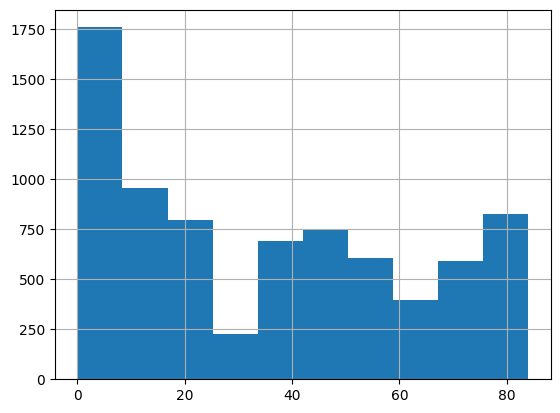

In [34]:
pd_dev['class'].hist();

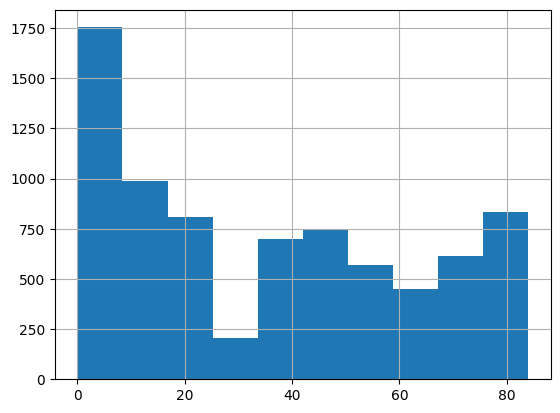

In [43]:
pd_test['class'].hist();

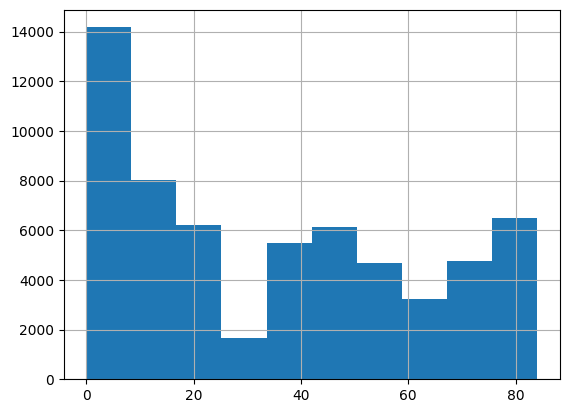

In [32]:
pd_train['class'].hist();

Можно посмотреть предсказания и долю ошибок на каждом классе и попробовать аугментировать данные прежде всего на слабо представленных в обучающей выборке классах

# Часть 4. [0.5 балла] Итоги
Напишите краткое резюме проделанной работы. Читали ли вы сами Гарри Поттера или фанфики о нем и помогло ли вам знание предметной области в выполнении домашнего задания?

1. Часть I

   - Задания по частоте слов: как будто выполнены полностью, результаты совпали с моими априорными представлениями об упоминании героев в оригинальных текстах (а так же насколько мне известно о фанфиках, популярные герои там +/- такие тоже)
   - Тк были во время выполнения задания проблемы со скачиванием оригинальных текстов, то работу пришлось строить относительно уже предобработаных 

2. Часть II
   - Обучил модели представления слов по аналогии с семинаров, поэтому все ожидаемо получилось. Word2Vec дает относительно внемяемые результаты на синонимах / исключениях слов / операциях с векторами слов. Но примеры в ноутбуке я оставил по наиболее характерным и популярным словам, понятно, что на других примерах может быть больше шума
   - Результаты визуализации порадовали: как минимум, образовались небольшие кластеры для слов с ярко выраженными значениями (не знаю, насколько уместно так говорить, моя интерпретация): время, перемещения, имена героев, речь (например 'said' и 'nodded' оказываются близки по смыслу, хотя синтаксически могут использоваться по-разному)

3. Часть III

   - fasttext оказался силен (f1 macro: 0.17), особенно после подбора гиперпараметров по сетке (он действительно фаст, поэтому такое с ним делается относительно просто)
   - Для работы с NN предобратал данные (опять же по аналогии с семинарами) и сделал dataloader'ы, которые в дальнейшем использовались при обучении и валидации всех реализаций
   - Сверточная NN относительно моих ожиданий, навыков в DL и первых результатов получилась неплохой. Поэксперемтировал с количеством фильтров и окнами, но по-хорошему надо еще попробовать использовать другие пулинги. Пока вывод (может быть очевидный для всех) но главный для меня - количество сверток реально решает, все таки нужно несколько разных слоев, для того чтобы улавливать сложные взаимосвязи слов в тексте. Разница между самой дефолтной реализацией и текущей искренне удивила (даже при не оч больших размерностях и кол-ве параметров)
   - LSTM так и не удалось заставить учиться. Пробовал все, что смог нагуглить / на чатгптить, но результаты метрик на каждой эпохе либо случайны, либо стагнируют. Почти наверное дело в моем все еще недостаточном понимании того, как они работают. (*Код в RNN представлен дефолтный без пуллинга и попыток в attention, тк откатывал все до +/- стартового состояния, чтобы позже попробовать еще, но по итогу не успеваю)
   - Аугментация и CNN так же порадовали, тк даже рандомная замена синонимами (причем сначала рандомная внутри текста, потом рандомный sample из выборки аугментированных текстов) дала ощутимый прирост (0.01 в f1-macro, относительно общих рез-ов, это ощутимо))). В идеале конечно желательно либо (а) прогнать бы ее именно над слабо представленными  классами, чтобы сбалансировать выборку, либо (б) проанализировать ошибки предсказаний модели и поработать над выборками по классам с худшими результатами

4. Часть IV
    - feci quod potui faciant meliora potentes